# Import and define functions

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import scipy.io as sio
import os
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import glob
import re

In [2]:
from scipy import stats

def calc_quantile(x, q):
    return x.quantile(q)

In [3]:
def r_to_p(r, n):
    '''
    for one-sided positive test only
    '''
    t = r / np.sqrt((1-r**2)/ (n-2) )
    p = stats.t.sf(t, df=n-2)   # positive only
    
    return p

def p_to_r(p, n):
    '''
    for one-sided positive test only, undoes r_to_p
    '''
    t_inv = stats.t.isf(p, df=n-2)
    r = np.sqrt(t_inv**2 / ( (n-2) * (1+t_inv**2/(n-2)) ))
    return r 

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.025)
def qupper(x):
    return x.quantile(0.975)


from scipy.stats import norm
def power_curve_1t(r, N):
    '''
    power curve for correlation (one-tailed, testing >0)
    '''
    # MATLAB code: power1 = 1 - cdf('Normal',1.96,atanh(r_true)*sqrt(N-3), 1);  % one tail
    N = np.array(N)  # allows for multiple N
    return 1-norm.cdf(x=1.645, loc=np.arctanh(r)*np.sqrt(N-3), scale=1)

In [4]:
'''
Load in sample size info
'''

df_sample_size = pd.read_csv('pheno_dataset_sample_size.csv')

# replace "attn" with "ap" (attention problems)
df_sample_size['pheno'] = df_sample_size['pheno'].replace('attn', 'ap')

# 20 points logspace from n=20 to n=max across all datasets/pheno
possible_n = np.round(np.logspace(np.log10(20), np.log10(df_sample_size.n_train.max()), 20))  # np.round(np.logspace(np.log10(20), np.log10(4149), 12)) 
possible_n = [int(p) for p in possible_n]

heldout_size_dict = dict(zip(df_sample_size[df_sample_size.pheno=='age'].dataset, 
                             df_sample_size[df_sample_size.pheno=='age'].n_heldout))

# Sample size analysis (lit review)

In [26]:
yeung_training = [89, 129, 276, 56, 25, 25, 32, 237, 673, 360, 25, 25, 163, 25, 87, 326, 17,
                  81, 48, 360, 33, 879, 644, 502, 571, 25, 25]
yeung_external = [86, 1791, 194, 36, 160, 242, 49, 137, 144, 200, 96, 113, 405, 113, 31, 53,
                  532, 155, 18, 109, 463, 34, 17, 67, 151, 157, 571]

print('Yeung training: {:.4f} ({:.4f}-{:.4f})'.format(np.median(yeung_training), 
                                                     np.percentile(yeung_training, 25),
                                                     np.percentile(yeung_training, 75) 
                                                     ))


print('Yeung external: {:.4f} ({:.4f}-{:.4f})'.format(np.median(yeung_external), 
                                                     np.percentile(yeung_external, 25),
                                                     np.percentile(yeung_external, 75) 
                                                     ))

Yeung training: 87.0000 (25.0000-343.0000)
Yeung external: 137.0000 (60.0000-197.0000)


In [27]:
our_training = [100, 874, 84, 53, 348, 129, 488, 274, 100, 70, 502, 220, 122, 673,
               120, 1721, 1309, 168, 563, 868, 161, 145, 81, 129, 375, 89, 36]
our_external = [1005, 97, 61, 43, 62, 163, 1033, 32, 71, 25, 1545, 294, 68, 831,
               65, 1030, 1309, 30, 533, 26, 20, 100, 18, 1701, 107, 94, 36]
np.median(our_external)

print('our training: {:.4f} ({:.4f}-{:.4f})'.format(np.median(our_training), 
                                                     np.percentile(our_training, 25),
                                                     np.percentile(our_training, 75) 
                                                     ))


print('our external: {:.4f} ({:.4f}-{:.4f})'.format(np.median(our_external), 
                                                     np.percentile(our_external, 25),
                                                     np.percentile(our_external, 75) 
                                                     ))

our training: 161.0000 (100.0000-495.0000)
our external: 94.0000 (39.5000-682.0000)


In [29]:
combined_training = np.hstack((our_training, yeung_training))
combined_external = np.hstack((our_external, yeung_external))

print('combined training: {:.4f} ({:.4f}-{:.4f})'.format(np.median(combined_training), 
                                                     np.percentile(combined_training, 25),
                                                     np.percentile(combined_training, 75) 
                                                     ))


print('combined external: {:.4f} ({:.4f}-{:.4f})'.format(np.median(combined_external), 
                                                     np.percentile(combined_external, 25),
                                                     np.percentile(combined_external, 75) 
                                                     ))

combined training: 129.0000 (59.5000-371.2500)
combined external: 108.0000 (50.0000-281.0000)


# Load main results

In [5]:
'''
Load in results dataframes (which were made on cluster)
Note: can skip this after doing it once and saving the necessary processed files below
'''

df_results = pd.DataFrame()
# loop over files to load results (each number is the file# in a predefined list that saved chunks of files)
for num in tqdm(['10000', '20000', '30000', '40000', '50000', '50899']):  
    df = pd.read_csv('results_' + num + '.csv')
    
    # remove abcd age due to not matching proper age ranges
    df = df[~((df.train_dataset=='abcd') & (df.pheno=='age'))].reset_index(drop=True)
    df = df[~((df.test_dataset=='abcd') & (df.pheno=='age'))].reset_index(drop=True)
    
    
    df_results = pd.concat([df_results, df])
    del df
df_results.head()

100%|██████████| 6/6 [02:24<00:00, 24.05s/it]


,train_dataset,pheno,test_dataset,train_seed,num_train,test_seed,num_test,r_internal,q2_internal,r_external,q2_external
0,pnc,mr,abcd,27,48,0,20,0.242741,-0.071633,-0.328627,-3.649567
1,pnc,mr,abcd,27,48,1,20,0.242741,-0.071633,0.062234,-5.963488
2,pnc,mr,abcd,27,48,2,20,0.242741,-0.071633,0.458842,-5.975585
3,pnc,mr,abcd,27,48,3,20,0.242741,-0.071633,0.058398,-4.483320
4,pnc,mr,abcd,27,48,4,20,0.242741,-0.071633,0.259013,-4.874014


In [7]:
# add in some new columns

# first get heldout size for within dataset internal validation
heldout_size_dict = dict({'abcd':3000, 'hbn':200, 'pnc':200, 'hcpd':100})
df_results['heldout_size'] = np.array([heldout_size_dict[d] for d in list(df_results.train_dataset)])

# now get p values for internal and external validation
df_results['p_internal'] = r_to_p(np.array(df_results.r_internal), np.array(df_results.heldout_size))
df_results['p_external'] = r_to_p(np.array(df_results.r_external), np.array(df_results.num_test))

# add column for combination of dataset and phenotype
df_results['test_dataset_pheno'] = df_results['test_dataset'] + '_' + df_results['pheno']
df_results['train_dataset_pheno'] = df_results['train_dataset'] + '_' + df_results['pheno']

# add in max training/test sizes
ntest_max_dict = dict( zip(list(df_sample_size['dataset'] + '_' + df_sample_size['pheno']), df_sample_size['n']) )
ntrain_max_dict = dict( zip(list(df_sample_size['dataset'] + '_' + df_sample_size['pheno']), df_sample_size['n_train']) )
df_results['ntest_max'] = list( map(ntest_max_dict.get, list(df_results['test_dataset_pheno']) ) )
df_results['ntrain_max'] = list( map(ntrain_max_dict.get, list(df_results['train_dataset_pheno']) ) )

In [10]:
del heldout_size_dict, df_sample_size, ntest_max_dict, ntrain_max_dict

In [11]:
# add in ground truth performances in cross-dataset
df_gt = pd.read_csv('./ground_truth/ground_truth.csv')
gt_r_dict = dict(zip(list(df_gt['train_dataset'] + '_' + df_gt['test_dataset'] + '_' + df_gt['pheno']),
                  list(df_gt.rval)))
gt_p_dict = dict(zip(list(df_gt['train_dataset'] + '_' + df_gt['test_dataset'] + '_' + df_gt['pheno']),
                  list(df_gt.pval)))
del df_gt

# map dictionaries
df_results['train_test_pheno'] = df_results['train_dataset'] + '_' + df_results['test_dataset'] + '_' + df_results['pheno']
df_results['r_gt'] = list( map(gt_r_dict.get, list(df_results['train_test_pheno']) ) )
df_results['p_gt'] = list( map(gt_p_dict.get, list(df_results['train_test_pheno']) ) )

In [12]:
# add in columns for significance
pthresh = 0.05
df_results['sig_internal'] = 1.0*(df_results['p_internal']<pthresh)
df_results['sig_external'] = 1.0*(df_results['p_external']<pthresh)
df_results['sig_gt'] = 1.0*(df_results['p_gt']<pthresh)

In [13]:
df_results.head()

,train_dataset,pheno,test_dataset,train_seed,num_train,test_seed,num_test,r_internal,q2_internal,r_external,...,test_dataset_pheno,train_dataset_pheno,ntest_max,ntrain_max,train_test_pheno,r_gt,p_gt,sig_internal,sig_external,sig_gt
0,pnc,mr,abcd,27,48,0,20,0.242741,-0.071633,-0.328627,...,abcd_mr,pnc_mr,7822.0,919.0,pnc_abcd_mr,0.029789,0.00421,1.0,0.0,1.0
1,pnc,mr,abcd,27,48,1,20,0.242741,-0.071633,0.062234,...,abcd_mr,pnc_mr,7822.0,919.0,pnc_abcd_mr,0.029789,0.00421,1.0,0.0,1.0
2,pnc,mr,abcd,27,48,2,20,0.242741,-0.071633,0.458842,...,abcd_mr,pnc_mr,7822.0,919.0,pnc_abcd_mr,0.029789,0.00421,1.0,1.0,1.0
3,pnc,mr,abcd,27,48,3,20,0.242741,-0.071633,0.058398,...,abcd_mr,pnc_mr,7822.0,919.0,pnc_abcd_mr,0.029789,0.00421,1.0,0.0,1.0
4,pnc,mr,abcd,27,48,4,20,0.242741,-0.071633,0.259013,...,abcd_mr,pnc_mr,7822.0,919.0,pnc_abcd_mr,0.029789,0.00421,1.0,0.0,1.0


# Within-dataset plots

In [5]:
loading = True  # set to false if needing to process data (i.e., only need to run and set to False one time)

if loading:
    df_within = pd.read_csv('./processed_csv_files/within.csv')
    
    # replace "attn" with "ap" (attention problems)
    df_within['pheno'] = df_within['pheno'].replace('attn', 'ap')
    
    df_within_grouped = pd.read_csv('./processed_csv_files/within_grouped.csv')
else:
    # get within-dataset dataframe as just any single test seed and test size 
    df_within = df_results.groupby(['train_dataset', 'pheno', 'num_train', 'train_seed'], 
                                   as_index=False).agg({'r_internal':'max',                                                                                                     'q2_internal':'max'})
    df_within.to_csv('./processed_csv_files/within.csv', index=False)

    # remove abcd age data (too small of an age range)
    df_within = df_within[~((df_within.train_dataset=='abcd') & (df_within.pheno=='age'))].reset_index(drop=True)
    
    # replace "attn" with "ap" (attention problems)
    df_within['pheno'] = df_within['pheno'].replace('attn', 'ap')
    
    # get median within datasets performance
    df_within_grouped = df_within.groupby(['train_dataset', 'pheno', 'num_train'],
                      as_index=False).agg(r_med=('r_internal', 'median'),
                                          r_lower=('r_internal', qlower),
                                          r_upper=('r_internal', qupper))
    df_within_grouped.to_csv('./processed_csv_files/within_grouped.csv', index=False)

# replace "attn" with "ap" (attention problems)
df_within_grouped['pheno'] = df_within_grouped['pheno'].replace('attn', 'ap')
    
df_within_grouped.head()

,train_dataset,pheno,num_train,r_med,r_lower,r_upper
0,abcd,ap,20,0.003192,-0.089582,0.104594
1,abcd,ap,27,-0.002298,-0.070873,0.085193
2,abcd,ap,36,0.006412,-0.062752,0.083072
3,abcd,ap,48,0.013486,-0.056519,0.084549
4,abcd,ap,64,0.015612,-0.052495,0.073812


/gpfs/gibbs/project/scheinost/mjr239/conda_envs/repro/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


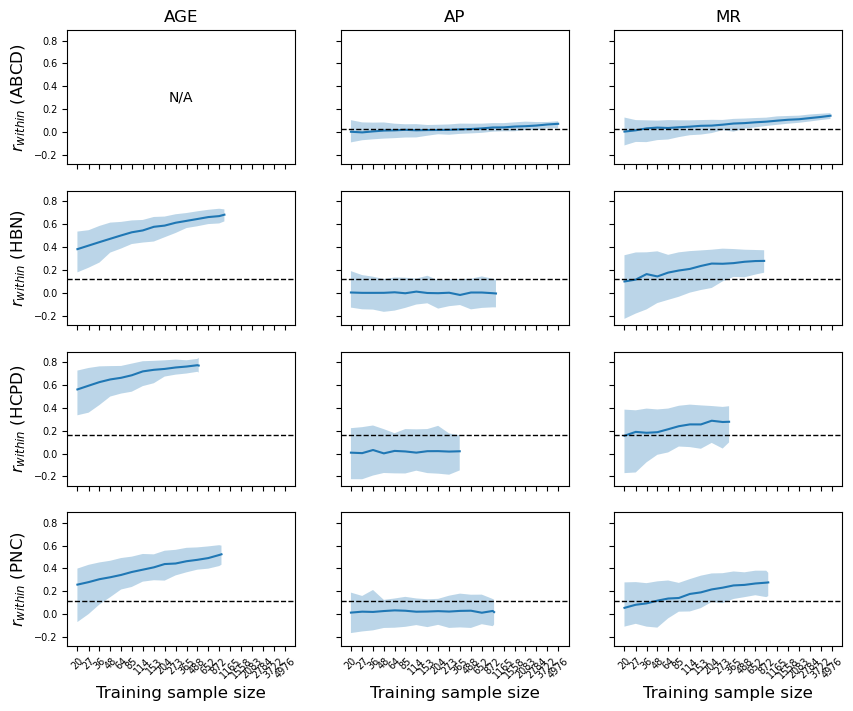

In [6]:
'''
Main figure for within-dataset performance in HBN
'''
dataset_all = ['abcd', 'hbn', 'hcpd', 'pnc']  # 'abcd', 'hbn', 'hcpd', 'pnc'
pheno_all = ['age', 'ap', 'mr']

fig, axs = plt.subplots(nrows=len(dataset_all), ncols=len(pheno_all),
                        figsize=(10, 2*len(dataset_all)), sharey=True, sharex=True)
if len(dataset_all)==1:
    axs = axs[None, :]

for dataset_idx, dataset in enumerate(dataset_all):
    for pheno_idx, pheno in enumerate(pheno_all):
        df_plot = df_within_grouped[(df_within_grouped.train_dataset==dataset) &
                                   (df_within_grouped.pheno==pheno)].reset_index(drop=True)
        
        if len(dataset_all)==1:
            possible_n_tmp = [int(p) for p in possible_n if p in df_plot.num_train.unique()]
        else:
            possible_n_tmp = [int(p) for p in possible_n]
            
        
        if len(df_plot)>0:
            # plot and fill
            axs[dataset_idx, pheno_idx].plot(df_plot.num_train, df_plot.r_med)
            axs[dataset_idx, pheno_idx].fill_between(df_plot.num_train,
                                                     df_plot.r_lower, df_plot.r_upper,
                                                    alpha=.3)
            
            
            # add in horizontal lines for significance
            axs[dataset_idx, pheno_idx].axhline(y=p_to_r(0.05, heldout_size_dict[dataset]), xmin=0, xmax=1000,
                                                color='black', linestyle='--', lw=1)
            
        else:
            axs[dataset_idx, pheno_idx].set_xticks([])
            axs[dataset_idx, pheno_idx].text(0.5, 0.5, 'N/A', transform=axs[dataset_idx, pheno_idx].transAxes,
                                            verticalalignment='center', horizontalalignment='center')
            

        
        # title
        if dataset_idx==0:
            axs[dataset_idx, pheno_idx].set_title(pheno.upper(), fontsize=12)
        if pheno_idx==0:
            axs[dataset_idx, pheno_idx].set_ylabel('$r_{within}$' +  ' ({:s})'.format(dataset.upper()), fontsize=12)
        if dataset_idx==(len(dataset_all)-1):
            axs[dataset_idx, pheno_idx].set_xlabel('Training sample size', fontsize=12)

        # tick parameters and settings
        axs[dataset_idx, pheno_idx].set_xscale('log')
        axs[dataset_idx, pheno_idx].xaxis.set_major_formatter(ScalarFormatter())
        axs[dataset_idx, pheno_idx].set_xticks(possible_n_tmp)
        axs[dataset_idx, pheno_idx].tick_params(axis='both', which='major', labelsize=7)
        for tick in axs[dataset_idx, pheno_idx].get_xticklabels():
            tick.set_rotation(45)
        # remove minor xticks (extra ticks)
        axs[dataset_idx, pheno_idx].set_xticks([], minor=True)

        
fig.savefig(os.path.join('./figures/','within_pred_' + '_'.join(dataset_all) + '.png'), 
            dpi=400, bbox_inches='tight')

Fraction of performance higher than ground truth

In [ ]:
# load ground truth
df_within_gt = pd.read_csv('./ground_truth/within_gt.csv')
df_within_gt = df_within_gt.rename(columns={'r':'r_within_gt', 'q2':'q2_within_gt'})

# replace "attn" with "ap" (attention problems)
df_within_gt['pheno'] = df_within_gt['pheno'].replace('attn', 'ap')

# add in ground truth to within file
df_within_with_gt = df_within.merge(df_within_gt, how='left',
                left_on=['train_dataset', 'pheno'],
               right_on=['dataset', 'pheno'])
df_within_with_gt['r_minus_gt'] = df_within_with_gt['r_internal'] - df_within_with_gt['r_within_gt']
df_within_with_gt['r_minus_gt_binary'] = 1.0*(df_within_with_gt['r_minus_gt']>.05)
df_within_inflated_grouped = df_within_with_gt.groupby(['train_dataset', 'num_train', 'pheno'],
                                                       as_index=False).agg(r_med=('r_internal', 'median'),
                                                                           r_gt=('r_within_gt', 'max'),
                                                                           fraction_inflated=('r_minus_gt_binary','mean'))

# # plot: note for sample size 
plot_sample_size = 204
print(df_within_inflated_grouped.num_train.unique())
df_plot = df_within_inflated_grouped[df_within_inflated_grouped.num_train==plot_sample_size].reset_index(drop=True)

# style changes for plot
df_plot['pheno'] = df_plot['pheno'].apply(lambda x: x.upper())
df_plot['train_dataset'] = df_plot['train_dataset'].apply(lambda x: x.upper())
df_plot = df_plot.rename(columns={'pheno':'Phenotype', 'train_dataset':'Training dataset'})

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df_plot, x='r_gt', y='fraction_inflated',
               hue='Phenotype', style='Training dataset', palette=sns.color_palette('colorblind')[:3])
ax.set_ylabel('Fraction of ' + '$\Delta r$' + '>0.05')
ax.set_xlabel('$r_{ground \ truth}$')
ax.set_title('N={:d}'.format(plot_sample_size))
plt.legend(fontsize=10) # make legend smaller
fig.savefig(os.path.join('./figures/','within_inflation_' + str(plot_sample_size) + '.png'), 
            dpi=400, bbox_inches='tight')

In [ ]:
'''
can print inflation percentage
'''
df_within_inflated_grouped[(df_within_inflated_grouped.train_dataset=='hbn') &
                          (df_within_inflated_grouped.num_train==204)]

# Power plots

In [5]:
loading = True  # set to false if needing to process data (i.e., only need to run and set to False one time)

if loading:
    df_power_grouped = pd.read_csv('./processed_csv_files/power.csv')
    
    # replace "attn" with "ap" (attention problems)
    df_power_grouped['pheno'] = df_power_grouped['pheno'].replace('attn', 'ap')
else:
    # calculate power as rate of significant results (for significant ground truth results only)
    df_power_grouped = df_results.groupby(['train_dataset', 'test_dataset', 'pheno', 'num_train', 'num_test'],
                          as_index=False).agg(pos_rate=('sig_external', 'mean'),
                                             sig_ground_truth=('sig_gt', 'mean'),
                                             r_ground_truth=('r_gt', 'max'))    
    df_power_grouped.to_csv('./processed_csv_files/power.csv', index=False)
df_power_grouped.head()

,train_dataset,test_dataset,pheno,num_train,num_test,pos_rate,sig_ground_truth,r_ground_truth
0,abcd,hbn,ap,20,20,0.0520,0.0,-0.009498
1,abcd,hbn,ap,20,27,0.0563,0.0,-0.009498
2,abcd,hbn,ap,20,36,0.0603,0.0,-0.009498
3,abcd,hbn,ap,20,48,0.0555,0.0,-0.009498
4,abcd,hbn,ap,20,64,0.0559,0.0,-0.009498


['abcd_hbn', 'abcd_hcpd', 'abcd_pnc', 'hcpd_abcd', 'hcpd_hbn', 'hcpd_pnc', 'pnc_abcd', 'pnc_hbn', 'pnc_hcpd']


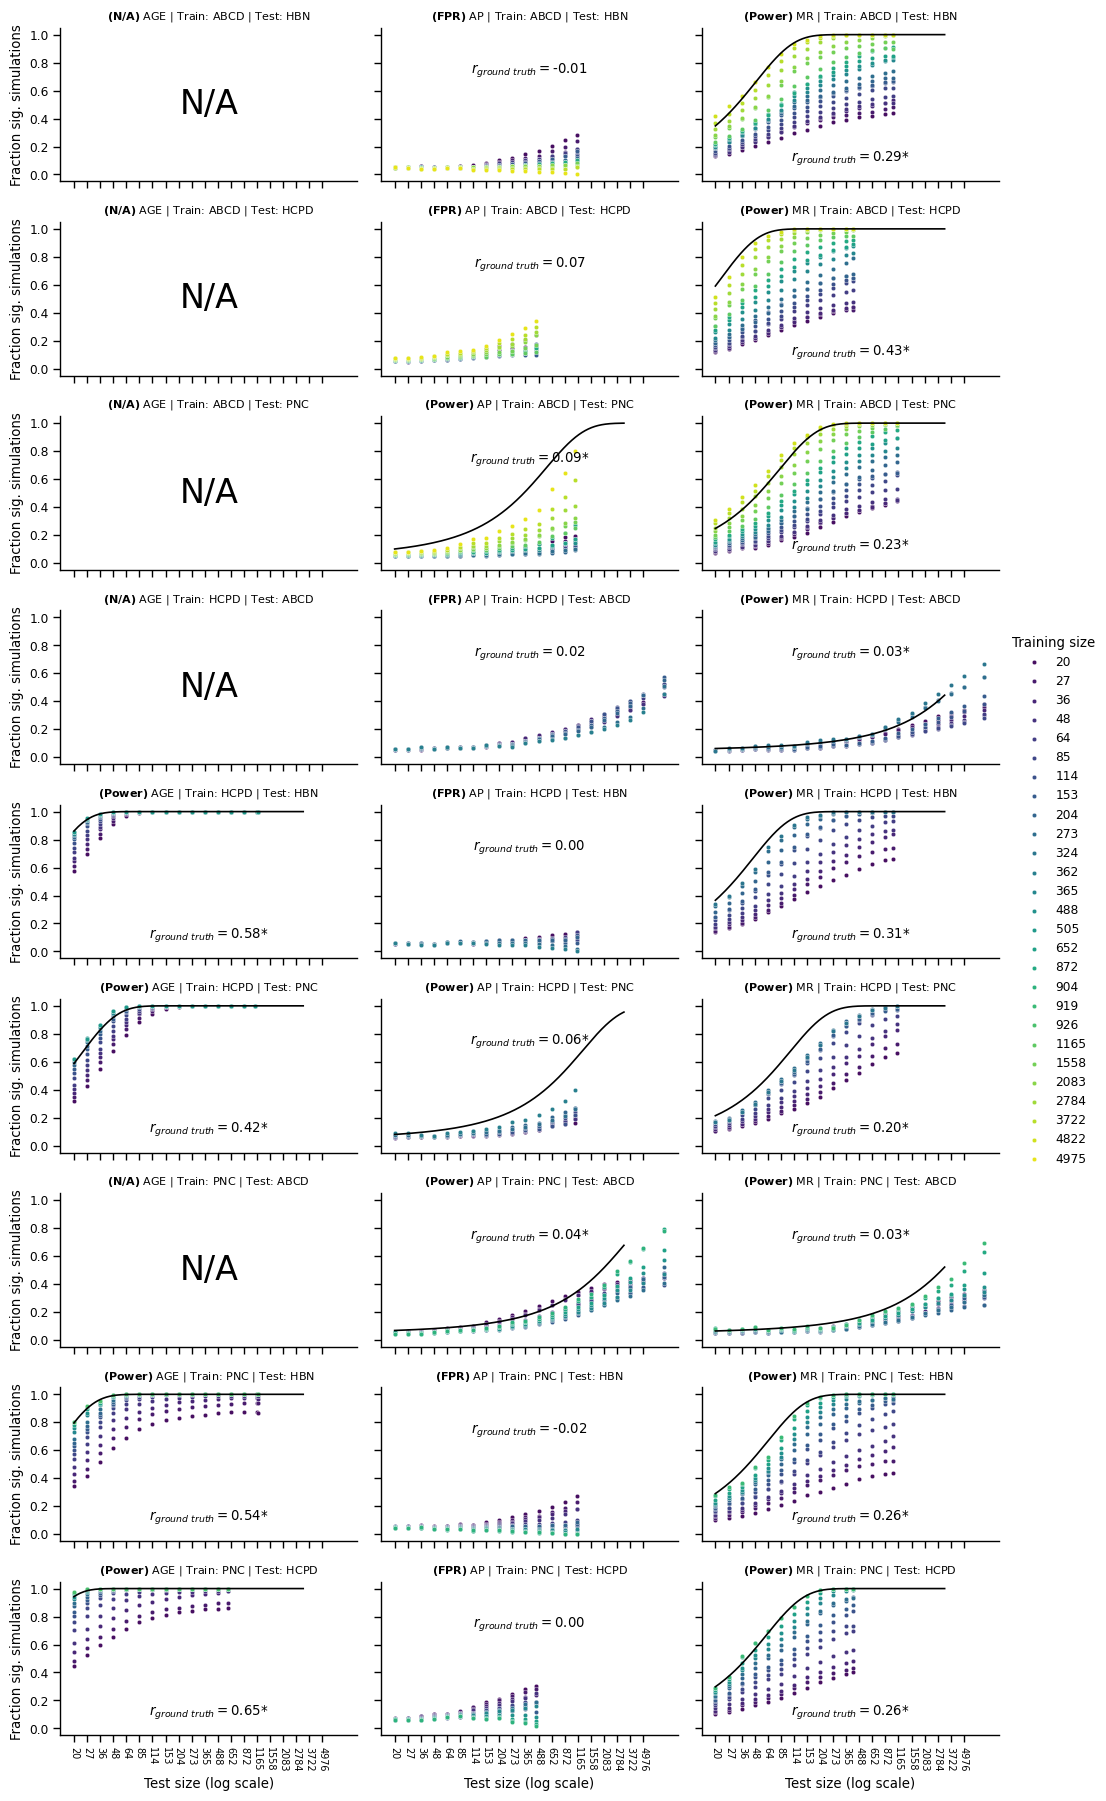

In [6]:
'''
Main figure for power in cross-dataset predictions for HBN
Can also adapt this for multiple training datasets at once
'''
sns.set_context('paper')

train_dataset = ['abcd', 'hcpd', 'pnc']  # 'hbn'     ['abcd', 'hcpd', 'pnc']
# train_dataset = 'hbn'

if type(train_dataset)==str:
    df_plot = df_power_grouped[df_power_grouped.train_dataset==train_dataset].reset_index(drop=True)
    row_order = [d for d in ['abcd', 'hbn', 'hcpd', 'pnc'] if d!=train_dataset]
    height = 2
    aspect = 1.3
    rowvar = 'test_dataset'
elif type(train_dataset)==list:  # if provided multiple training datasets
    df_plot = df_power_grouped[df_power_grouped.train_dataset.isin(train_dataset)].reset_index(drop=True)
    df_plot['traintest'] = df_plot['train_dataset'] + '_' + df_plot['test_dataset']
    all_test_datasets = list(df_plot.test_dataset.unique())
    row_order = [t + '_' + t2 for t2 in all_test_datasets for t in train_dataset if (t!=t2)]
    row_order.sort()
    print(row_order)

    height = 2
    aspect = 1.7
    
    rowvar = 'traintest'
    
g = sns.FacetGrid(df_plot, col="pheno",  row=rowvar, hue='num_train',
                  palette=sns.color_palette("viridis", len(df_plot.num_train.unique())),
                 row_order=row_order, col_order=['age', 'ap', 'mr'],
                 height=height, aspect=aspect)
g.map(sns.scatterplot, "num_test", "pos_rate", s=10).set(xscale = 'log')
g.set_xlabels('Test size (log scale)')
g.add_legend(title='Training size')

# iterate over axes of FacetGrid
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks([], minor=True)  # remove minor xticks
    ax.set_xticks([s for s in df_power_grouped.num_test.unique() if s in possible_n])
    ax.xaxis.set_major_formatter(ScalarFormatter())

    for tick in ax.get_xticklabels():
        tick.set_rotation(270)
#     ax.set_xticklabels(ax.get_xticklabels, fontsize=20)
    # change the fontsize
    ax.tick_params(axis='x', labelsize=7)
        
    # get plots for theoretical power curves
    title_txt = g.axes.flat[i].title.get_text()
    txt_tmp = title_txt.split('|')
    txt_tmp = [tmp.split('=') for tmp in txt_tmp]
    pheno_name = txt_tmp[1][-1].strip()
    
    # get ground truth values - depends on how many training datasets
    if type(train_dataset)==str:
        test_dataset_name = txt_tmp[0][-1].strip()
        r_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                            (df_plot.test_dataset==test_dataset_name), 
                             'r_ground_truth'].mean()  # mean should be the same as taking first
        sig_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                    (df_plot.test_dataset==test_dataset_name), 
                     'sig_ground_truth'].mean()    
    elif type(train_dataset)==list:
        traintest_dataset_name = txt_tmp[0][-1].strip()
        train_dataset_name, test_dataset_name = traintest_dataset_name.split('_')
        r_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                            (df_plot.test_dataset==test_dataset_name) &
                           (df_plot.train_dataset==train_dataset_name), 
                             'r_ground_truth'].mean()  # mean should be the same as taking first
        sig_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                            (df_plot.test_dataset==test_dataset_name) &
                           (df_plot.train_dataset==train_dataset_name), 
                             'sig_ground_truth'].mean()
#         print('Train: {:s}, test: {:s}, r: {:.2f}'.format(train_dataset_name, test_dataset_name, r_gt))
    if r_gt>0.2:  # where to add "r=" text on plot
        r_text_y_loc = 0.15
    else:
        r_text_y_loc = 0.72
    

    N_all = np.arange(20, 3251)
    
    if sig_gt==1:  # power
        power_curve = power_curve_1t(r_gt, N_all)
        ax.plot(N_all, power_curve, color='black')
        
        if type(train_dataset)==str:
            ax.set_title(r'$\bf{(Power)}$' + ' ' + pheno_name.upper() + ' | Test: ' + test_dataset_name.upper())
        elif type(train_dataset)==list:
             ax.set_title(r'$\bf{(Power)}$' + ' ' + pheno_name.upper() + ' | Train: ' + train_dataset_name.upper() + ' | Test: ' + test_dataset_name.upper(),
                    fontsize=8)
            
        # put ground truth performance on plot
        ax.text(0.5, r_text_y_loc, '$r_{ground \ truth}=$' + '{:.2f}*'.format(r_gt),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
    elif sig_gt==0:  # false positive rate
        
        if type(train_dataset)==str:
            ax.set_title(r'$\bf{(FPR)}$' + ' ' + pheno_name.upper() + ' | Test: ' + test_dataset_name.upper())
        elif type(train_dataset)==list:
            ax.set_title(r'$\bf{(FPR)}$' + ' ' + pheno_name.upper() + ' | Train: ' + train_dataset_name.upper() + ' | Test: ' + test_dataset_name.upper(),
                fontsize=8)

        # put ground truth performance on plot
        ax.text(0.5, r_text_y_loc, '$r_{ground \ truth}=$' + '{:.2f}'.format(r_gt),
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
    else:  # no prediction
        if type(train_dataset)==str:
            ax.set_title(r'$\bf{(N/A)}$' + ' ' + pheno_name.upper() + ' | Test: ' + test_dataset_name.upper())
        elif type(train_dataset)==list:
            ax.set_title(r'$\bf{(N/A)}$' + ' ' + pheno_name.upper() + ' | Train: ' + train_dataset_name.upper() + ' | Test: ' + test_dataset_name.upper(),
                fontsize=8)
        
        left, width = .25, .5
        bottom, height = .25, .5
        top = bottom + height
        right = left + width
        ax.text(left+width/2, 0.5 * (bottom + top), 'N/A',
                horizontalalignment='center',
                verticalalignment='center',\
                rotation='horizontal',
                fontsize=24,
                transform=ax.transAxes)
    # set y label
    ax.set_ylabel('Fraction sig. simulations')
plt.show()

if type(train_dataset)==str:
    g.savefig(os.path.join('./figures/cross_power_' + train_dataset + '.png'),
              dpi=400, bbox_inches='tight')
else:
    g.savefig(os.path.join('./figures/cross_power_' + '_'.join(train_dataset) + '.png'),
          dpi=400, bbox_inches='tight')

Printing some power summary stats

In [7]:
'''
Can use this to print power for various conditions
'''
df_print = df_power_grouped[(df_power_grouped.pheno=='age') & 
                (df_power_grouped.num_train==20)].reset_index(drop=True).reset_index(drop=True)

# merge in max test size
df_pheno_sample_size = pd.read_csv('./pheno_dataset_sample_size.csv')
df_pheno_sample_size = df_pheno_sample_size.rename(columns={'n':'num_test_max'})
df_print = df_print.merge(df_pheno_sample_size[['dataset', 'pheno', 'num_test_max']], how='left', 
               left_on=['test_dataset', 'pheno'],
              right_on=['dataset', 'pheno'])
df_print = df_print[df_print.num_test==df_print.num_test_max].reset_index(drop=True)
df_print

,train_dataset,test_dataset,pheno,num_train,num_test,pos_rate,sig_ground_truth,r_ground_truth,dataset,num_test_max
0,hbn,hcpd,age,20,605,0.95,1.0,0.725849,hcpd,605
1,hbn,pnc,age,20,1126,0.98,1.0,0.477695,pnc,1126
2,hcpd,hbn,age,20,1201,1.00,1.0,0.579513,hbn,1201
3,hcpd,pnc,age,20,1126,1.00,1.0,0.423787,pnc,1126
4,pnc,hbn,age,20,1201,0.87,1.0,0.536288,hbn,1201
5,pnc,hcpd,age,20,605,0.86,1.0,0.652602,hcpd,605


In [ ]:
df_pheno_sample_size = pd.read_csv('./pheno_dataset_sample_size.csv')

# replace "attn" with "ap" (attention problems)
df_pheno_sample_size['pheno'] = df_pheno_sample_size['pheno'].replace('attn', 'ap')

df_pheno_sample_size

Printing more power stats for end of results section 3.3 power

In [16]:
'''
print out inflation by sample size
'''

df_tmp = df_power_grouped[(df_power_grouped.sig_ground_truth==1) & 
               (df_power_grouped.num_train==64) &
              (df_power_grouped.num_test==48)].sort_values(by='pos_rate')  # .groupby(['train_dataset', 'test_dataset', 'pheno'],as_index=False).agg({'pos_rate':'median'})

df_tmp
df_tmp[df_tmp.pheno=='mr']

,train_dataset,test_dataset,pheno,num_train,num_test,pos_rate,sig_ground_truth,r_ground_truth
5419,pnc,abcd,mr,64,48,0.0567,1.0,0.029789
3810,hcpd,abcd,mr,64,48,0.0584,1.0,0.026371
1443,abcd,pnc,mr,64,48,0.1479,1.0,0.228716
4915,hcpd,pnc,mr,64,48,0.2343,1.0,0.204271
3345,hbn,pnc,mr,64,48,0.2561,1.0,0.222901
363,abcd,hbn,mr,64,48,0.2569,1.0,0.294700
891,abcd,hcpd,mr,64,48,0.2681,1.0,0.425930
6175,pnc,hbn,mr,64,48,0.2724,1.0,0.258998
6763,pnc,hcpd,mr,64,48,0.2996,1.0,0.263818
4390,hcpd,hbn,mr,64,48,0.3281,1.0,0.305683


In [ ]:
df_tmp = df_power_grouped[(df_power_grouped.sig_ground_truth==1) & 
               (df_power_grouped.num_train==85) &
              (df_power_grouped.num_test==114)].sort_values(by='pos_rate')  # .groupby(['train_dataset', 'test_dataset', 'pheno'],as_index=False).agg({'pos_rate':'median'})

df_tmp
df_tmp[df_tmp.pheno=='ap']

# Effect size inflation

In [17]:
loading = True  # set to false if needing to process data (i.e., only need to run and set to False one time)

if loading:
    df_effect_size = pd.read_csv('./processed_csv_files/effect_size_inflation.csv')
    
    # replace "attn" with "ap" (attention problems)
    df_effect_size['pheno'] = df_effect_size['pheno'].replace('attn', 'ap')
    
else:
    # calculate median performance
    df_effect_size = df_results.groupby(['train_dataset', 'test_dataset', 'pheno', 'num_train', 'num_test', 'sig_external'],
                          as_index=False).agg(r_med=('r_external', 'median'),
                                             r_ground_truth=('r_gt', 'max'),
                                             sig_ground_truth=('sig_gt', 'max'))
    
    # add in column for inflation of effects relative to ground truth
    df_effect_size['infl_med'] = df_effect_size['r_med'] - df_effect_size['r_ground_truth']  # difference between test and ground truth
    df_effect_size.to_csv('./processed_csv_files/effect_size_inflation.csv', index=False)

df_effect_size.head()

,train_dataset,test_dataset,pheno,num_train,num_test,sig_external,r_med,r_ground_truth,sig_ground_truth,infl_med
0,abcd,hbn,ap,20,20,0.0,-0.025171,-0.009498,0.0,-0.015673
1,abcd,hbn,ap,20,20,1.0,0.445137,-0.009498,0.0,0.454634
2,abcd,hbn,ap,20,27,0.0,-0.020392,-0.009498,0.0,-0.010895
3,abcd,hbn,ap,20,27,1.0,0.375323,-0.009498,0.0,0.384821
4,abcd,hbn,ap,20,36,0.0,-0.018891,-0.009498,0.0,-0.009393


['abcd_hbn', 'abcd_hcpd', 'abcd_pnc', 'hcpd_abcd', 'hcpd_hbn', 'hcpd_pnc', 'pnc_abcd', 'pnc_hbn', 'pnc_hcpd']


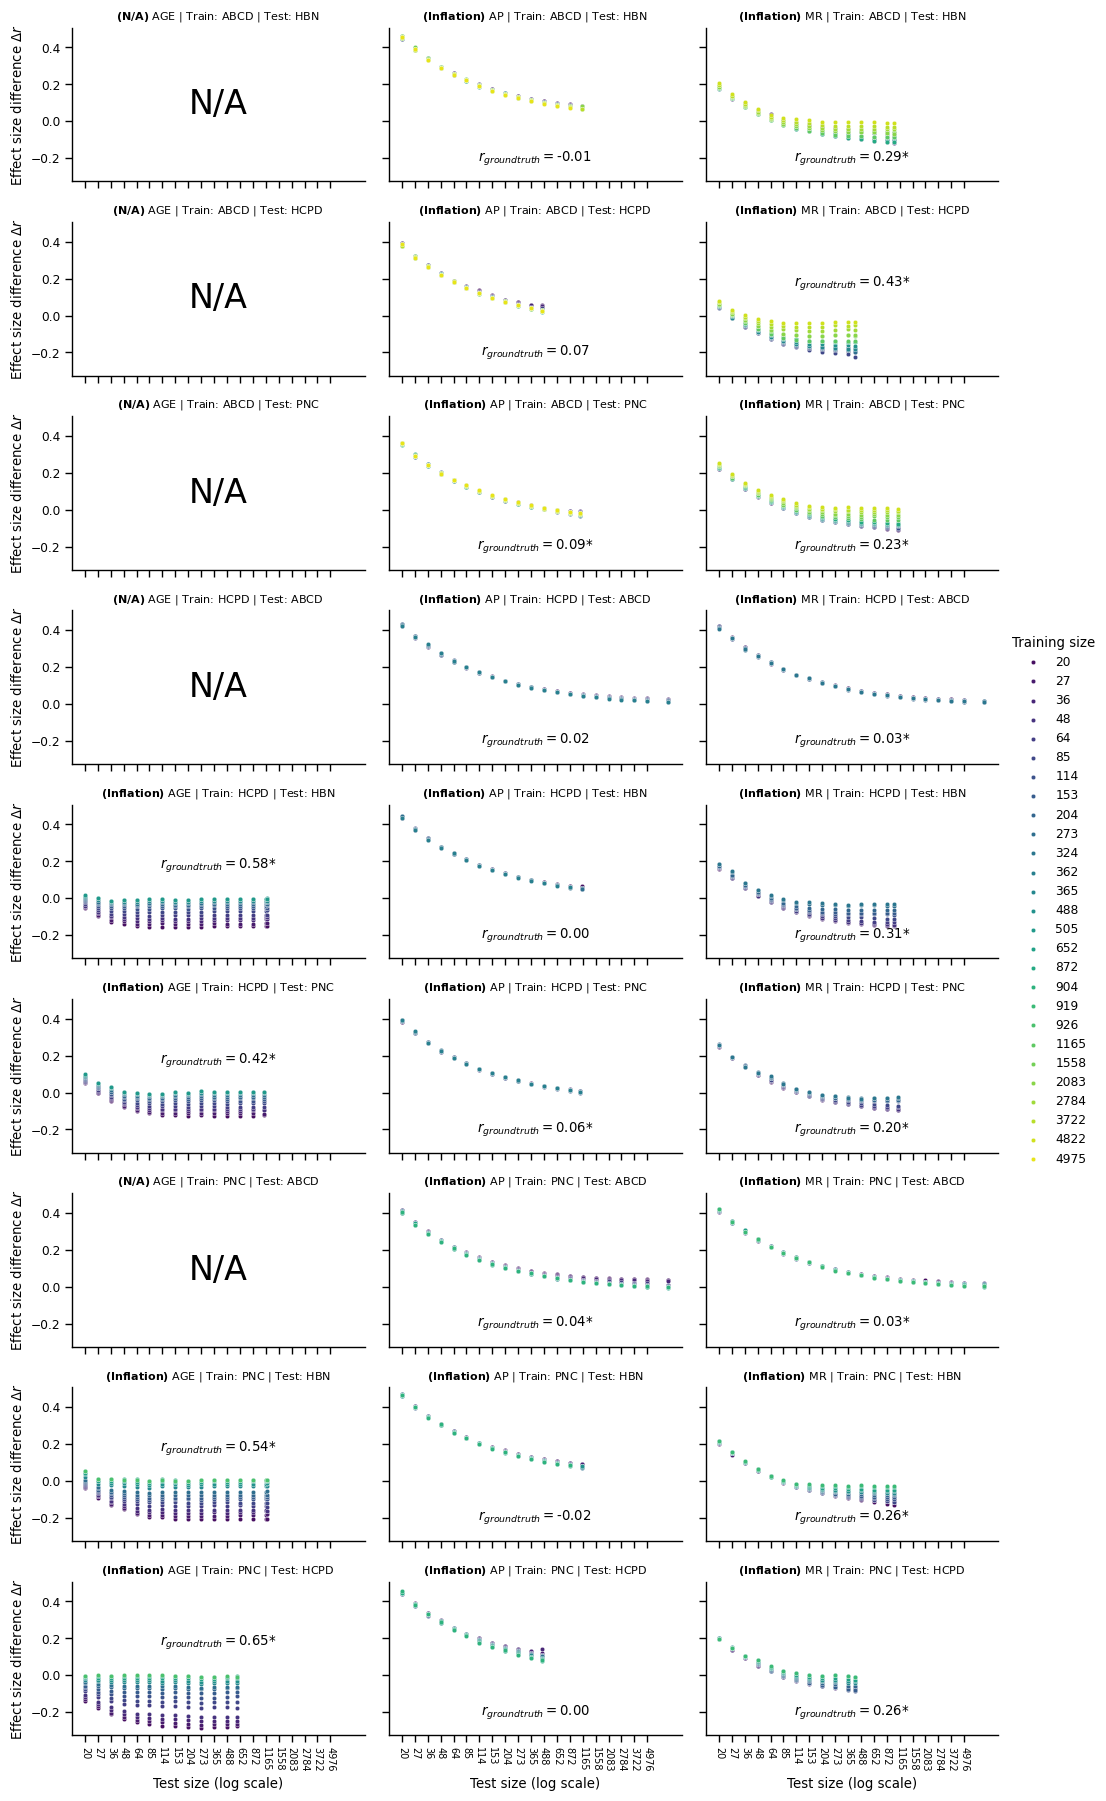

In [18]:
sns.set_context('paper')


train_dataset = ['abcd', 'hcpd', 'pnc']  # 'hbn'   ['abcd', 'hcpd', 'pnc']

# get only training dataset of interest and those with significant results (for purpose of evaluating effect size inflation)
if type(train_dataset)==str:
    df_plot = df_effect_size[(df_effect_size.train_dataset==train_dataset) & 
                        (df_effect_size.sig_external==1)].reset_index(drop=True)
    row_order = [d for d in ['abcd', 'hbn', 'hcpd', 'pnc'] if d!=train_dataset]
    height = 2
    aspect = 1.3
    rowvar = 'test_dataset'
elif type(train_dataset)==list:  # if provided multiple training datasets
    df_plot = df_effect_size[df_effect_size.train_dataset.isin(train_dataset) & 
                        (df_effect_size.sig_external==1)].reset_index(drop=True)
    df_plot['traintest'] = df_plot['train_dataset'] + '_' + df_plot['test_dataset']
    all_test_datasets = list(df_plot.test_dataset.unique())
    row_order = [t + '_' + t2 for t2 in all_test_datasets for t in train_dataset if (t!=t2)]
    row_order.sort()
    print(row_order)

    height = 2
    aspect = 1.7
    
    rowvar = 'traintest'
    
    
g = sns.FacetGrid(df_plot, col="pheno",  row=rowvar, hue='num_train',
                 row_order=row_order, col_order=['age', 'ap', 'mr'],
                 palette=sns.color_palette("viridis", len(df_plot.num_train.unique())),
                 height=height, aspect=aspect)
g.map(sns.scatterplot, "num_test", "infl_med", s=10).set(xscale = 'log')
g.set_xlabels('Test size (log scale)')
g.add_legend(title='Training size')


# iterate over axes of FacetGrid
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks([], minor=True)  # remove minor xticks
    ax.set_xticks([s for s in df_plot.num_test.unique() if s in possible_n])
    ax.xaxis.set_major_formatter(ScalarFormatter())

    for tick in ax.get_xticklabels():
        tick.set_rotation(270)
    ax.tick_params(axis='x', labelsize=7)
        
    # get plots for theoretical power curves
    title_txt = g.axes.flat[i].title.get_text()
    txt_tmp = title_txt.split('|')
    txt_tmp = [tmp.split('=') for tmp in txt_tmp]
    test_dataset_name = txt_tmp[0][-1].strip().split('_')[-1]
#     train_dataset_name = txt_tmp[0][-1].strip().split('_')[0]

    pheno_name = txt_tmp[1][-1].strip()
    
    
    
    # get ground truth values - depends on how many training datasets
    if type(train_dataset)==str:
        test_dataset_name = txt_tmp[0][-1].strip()
            

        r_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                            (df_plot.test_dataset==test_dataset_name), 
                             'r_ground_truth'].mean()  # mean should be the same as taking first
        sig_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                    (df_plot.test_dataset==test_dataset_name), 
                     'sig_ground_truth'].mean()   
        
    elif type(train_dataset)==list:
        traintest_dataset_name = txt_tmp[0][-1].strip()
        train_dataset_name, test_dataset_name = traintest_dataset_name.split('_')
        r_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                            (df_plot.test_dataset==test_dataset_name) &
                           (df_plot.train_dataset==train_dataset_name), 
                             'r_ground_truth'].mean()  # mean should be the same as taking first
        sig_gt = df_plot.loc[(df_plot.pheno==pheno_name) & 
                            (df_plot.test_dataset==test_dataset_name) &
                           (df_plot.train_dataset==train_dataset_name), 
                             'sig_ground_truth'].mean()
    
    if sig_gt==1:
        sig_gt_str='*'
    else:
        sig_gt_str=''
    
    N_all = np.arange(20, 3251)
    
    if ~np.isnan(r_gt):
        
        if type(train_dataset)==str:
            ax.set_title(r'$\bf{(Inflation)}$' + ' ' + pheno_name.upper() + ' | Test: ' + test_dataset_name.upper())
        elif type(train_dataset)==list:
            ax.set_title(r'$\bf{(Inflation)}$' + ' ' + pheno_name.upper()  + ' | Train: ' + train_dataset_name.upper() + ' | Test: ' + test_dataset_name.upper(),
                        fontsize=8)
            

        # just so points dont overlap with text
        if r_gt>.4:
            gt_yloc = 0.6
        else:
            gt_yloc = 0.15
        
        # put ground truth performance on plot
        ax.text(0.5, gt_yloc, '$r_{ground truth}=$' + '{:.2f}'.format(r_gt) + sig_gt_str,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
    else:  # if prediction is missing (e.g., abcd no age)
        if type(train_dataset)==str:
            ax.set_title(r'$\bf{(N/A)}$' + ' ' + pheno_name.upper() + ' | Test: ' + test_dataset_name.upper())
        elif type(train_dataset)==list:
            ax.set_title(r'$\bf{(N/A)}$' + ' ' + pheno_name.upper()  + ' | Train: ' + train_dataset_name.upper() + ' | Test: ' + test_dataset_name.upper(),
                        fontsize=8)
        
        left, width = .25, .5
        bottom, height = .25, .5
        top = bottom + height
        right = left + width
        ax.text(left+width/2, 0.5 * (bottom + top), 'N/A',
                horizontalalignment='center',
                verticalalignment='center',\
                rotation='horizontal',
                fontsize=24,
                transform=ax.transAxes)

    ax.set_ylabel('Effect size difference ' + '$\Delta r$')
    
if type(train_dataset)==str:
    g.savefig(os.path.join('./figures/inflation_' + train_dataset + '.png'),
              dpi=400, bbox_inches='tight')
else:
    g.savefig(os.path.join('./figures/inflation_' + '_'.join(train_dataset) + '.png'),
          dpi=400, bbox_inches='tight')

printing out inflations at various sample sizes

In [27]:
'''
print out inflation by sample size
'''

df_tmp = df_effect_size[(df_effect_size.sig_external==1) & 
               (df_effect_size.num_train==365) &
              (df_effect_size.num_test==273)].groupby(['train_dataset', 'test_dataset', 'pheno'],
                                                     as_index=False).agg({'infl_med':'median'})


df_tmp[df_tmp.pheno=='mr'].sort_values(by='infl_med')

,train_dataset,test_dataset,pheno,infl_med
3,abcd,hcpd,mr,-0.174529
1,abcd,hbn,mr,-0.076679
5,abcd,pnc,mr,-0.058741
20,pnc,hbn,mr,-0.053169
23,pnc,hcpd,mr,-0.033441
13,hbn,pnc,mr,-0.021519
10,hbn,hcpd,mr,-0.001575
17,pnc,abcd,mr,0.092341
7,hbn,abcd,mr,0.152747


# Relating internal and external performance

In [5]:
loading = True  # set to false if needing to process data (i.e., only need to run and set to False one time)

if loading:
    df_fulltest = pd.read_csv('./processed_csv_files/fulltest.csv')
     
    # replace "attn" with "ap" (attention problems)
    df_fulltest['pheno'] = df_fulltest['pheno'].replace('attn', 'ap')   
    
    df_fulltest['internal_external_diff'] = df_fulltest.r_internal - df_fulltest.r_external
else:
    # calculate difference between internal and external performance
    df_results['internal_external_diff'] = df_results.r_external - df_results.r_internal
    
    # take only data at full test sample size
    df_fulltest = df_results[(df_results.num_test==df_results.ntest_max) & 
                            (df_results.test_seed==0)].reset_index(drop=True)
    df_fulltest.to_csv('./processed_csv_files/fulltest.csv', index=False)

In [6]:
df_external_internal = df_fulltest.groupby(['train_dataset', 'test_dataset', 'pheno', 'num_train', 'num_test'],
                      as_index=False).agg(internal_external_diff_med=('internal_external_diff', 'median'))
df_external_internal.head()

,train_dataset,test_dataset,pheno,num_train,num_test,internal_external_diff_med
0,abcd,hbn,ap,20,1150,0.007076
1,abcd,hbn,ap,27,1150,0.005466
2,abcd,hbn,ap,36,1150,0.014625
3,abcd,hbn,ap,48,1150,0.013691
4,abcd,hbn,ap,64,1150,0.018422


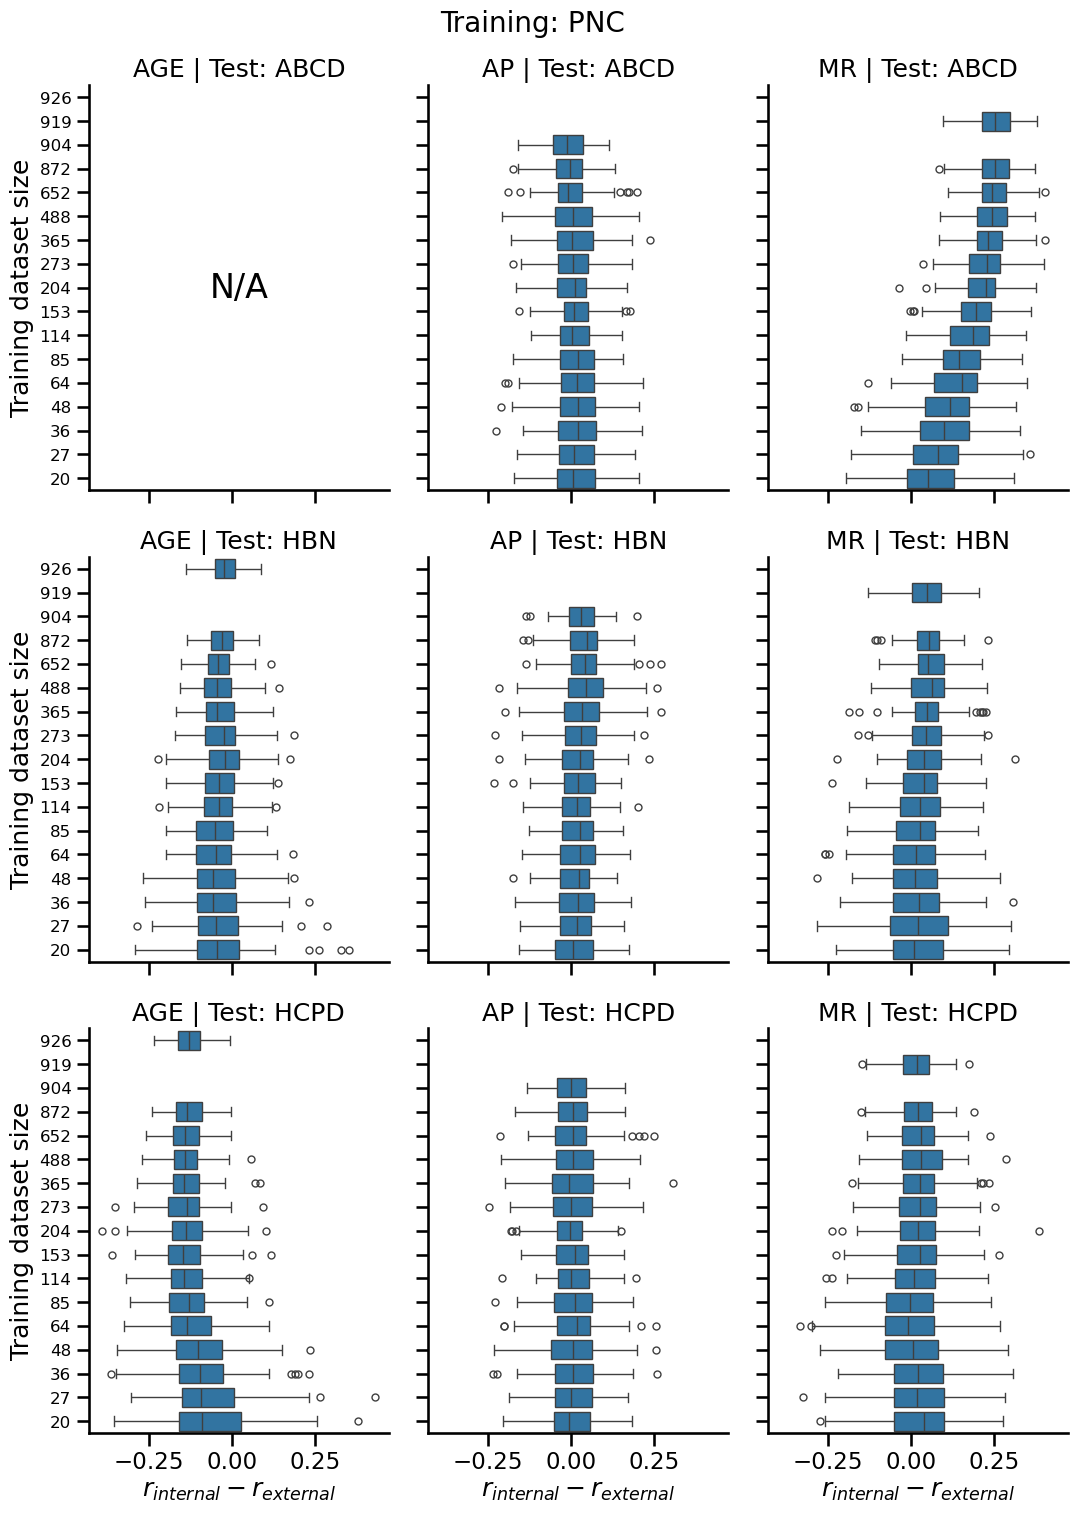

pnc


In [41]:
train_dataset_name = 'pnc'
zero_clip = False
if train_dataset_name=='hbn':
    aspect=1
else:
    aspect=0.75
    
df_plot = df_fulltest[(df_fulltest.train_dataset==train_dataset_name)].reset_index(drop=True)

# clip negative performance to zero
if zero_clip:
    df_plot['r_internal'] = df_plot['r_internal'].clip(lower=0)
    df_plot['r_external'] = df_plot['r_external'].clip(lower=0)


df_plot['num_train'] = df_plot['num_train'].astype('str')  # convert to string to avoid log scaling catplot issue in seaborn


sns.set_context('talk')
row_order = [a for a in ['abcd', 'hbn', 'hcpd', 'pnc'] if a!=train_dataset_name]
g = sns.catplot(
    data=df_plot, x='internal_external_diff', y='num_train',
    col='pheno', row='test_dataset', kind='box', 
    row_order=row_order,
    col_order=['age', 'ap', 'mr'],
    order=[str(val) for val in np.sort(df_plot.num_train.unique().astype(int))[::-1] ],
    aspect=aspect,
    margin_titles=False
)
g.set_axis_labels('$r_{internal} - r_{external}$', 'Training dataset size')

# add text
g.fig.text(0.5, 1.005, 'Training: {:s}'.format(train_dataset_name.upper()),
           ha='center', va='center', fontsize=20)

g.savefig(os.path.join('./figures/','internal_external_' + train_dataset_name + '.png'),
              dpi=400, bbox_inches='tight')

# iterate over axes of FacetGrid
for i, ax in enumerate(g.axes.flat):

    # Add N/A if relevant
    if not ax.lines:              
        left, width = .25, .5
        bottom, height = .25, .5
        top = bottom + height
        right = left + width
        ax.text(left+width/2, 0.5 * (bottom + top), 'N/A',
                horizontalalignment='center',
                verticalalignment='center',\
                rotation='horizontal',
                fontsize=24,
                transform=ax.transAxes)
    
    ax.tick_params(axis='y', labelsize=12)
    
    # edit title text
    title_txt = g.axes.flat[i].title.get_text()
    txt_tmp = title_txt.split('|')
    txt_tmp = [tmp.split('=') for tmp in txt_tmp]
    pheno_name = txt_tmp[1][-1].strip()
    test_dataset_name = txt_tmp[0][-1].strip()
    ax.set_title(pheno_name.upper() + ' | Test: ' + test_dataset_name.upper())
  
plt.show()
print(train_dataset_name)
if zero_clip:  # change name for zero clip 
    g.savefig(os.path.join('./figures/','internal_external_' + train_dataset_name + '_zeroclip.png'),
              dpi=400, bbox_inches='tight')
else:
    g.savefig(os.path.join('./figures/','internal_external_' + train_dataset_name + '.png'),
              dpi=400, bbox_inches='tight')

Below seeing fraction of internal minus external

In [7]:
# add in two binary columns for whether it is within threshold
df_fulltest['internal_external_diff_0.2'] = list(df_fulltest['internal_external_diff']<0.2)
df_fulltest['internal_external_diff_0.1'] = list(df_fulltest['internal_external_diff']<0.1)

In [8]:
'''
For each training sample size, find proportion of evaluations within thresholds of 0.1 and 0.2 for 
(r_within - r_external)
'''
df_fulltest.groupby([ 'num_train'],
                      as_index=False).agg(internal_external_diff_2=('internal_external_diff_0.2', 'mean'),
                                         internal_external_diff_1=('internal_external_diff_0.1', 'mean'))

,num_train,internal_external_diff_2,internal_external_diff_1
0,20,0.907000,0.737667
1,27,0.900333,0.733333
2,36,0.894000,0.724333
3,48,0.889667,0.729000
4,64,0.882333,0.725667
5,85,0.876333,0.721333
6,114,0.865667,0.711000
7,153,0.858667,0.703000
8,204,0.849000,0.703000
9,273,0.845667,0.712000


In [10]:
'''
Includes ratio of internal to external performance
'''
df_tmp = df_fulltest[df_fulltest.sig_internal==1].reset_index(drop=True)
df_tmp['int_ext_ratio'] = df_tmp['r_internal'] / df_tmp['r_external']
df_tmp['int_ext_ratio_binary_1.1'] = df_tmp['int_ext_ratio']<1.1
df_tmp['int_ext_ratio_binary_1.2'] = df_tmp['int_ext_ratio']<1.2
df_tmp['int_ext_ratio_binary_1.5'] = df_tmp['int_ext_ratio']<1.5

df_tmp['int_ext_fractional_inflation'] = (df_tmp['r_internal'] - df_tmp['r_external'] ) / df_tmp['r_internal']

df_tmp.groupby([ 'num_train'],
                      as_index=False).agg(internal_external_diff_2=('internal_external_diff_0.2', 'mean'),
                                         internal_external_diff_1=('internal_external_diff_0.1', 'mean'),
                                         sig_internal=('sig_internal', 'mean'),
                                         sig_external=('sig_external', 'mean'),
                                         r_internal=('r_internal', 'mean'),
                                         r_external=('r_external', 'mean'),
                                         r_ratio=('int_ext_ratio', 'median'),
                                          r_ratio_1=('int_ext_ratio_binary_1.1', 'mean'),
                                          r_ratio_2=('int_ext_ratio_binary_1.2', 'mean'),
                                          r_ratio_5=('int_ext_ratio_binary_1.5', 'mean'),
                                         r_frac_infl=('int_ext_fractional_inflation', 'median'))

,num_train,internal_external_diff_2,internal_external_diff_1,sig_internal,sig_external,r_internal,r_external,r_ratio,r_ratio_1,r_ratio_2,r_ratio_5,r_frac_infl
0,20,0.802794,0.545604,1.0,0.806902,0.281090,0.203717,1.187928,0.456861,0.501233,0.641742,0.298239
1,27,0.789760,0.535299,1.0,0.787432,0.287339,0.209055,1.162750,0.471683,0.514352,0.653995,0.305334
2,36,0.777370,0.534901,1.0,0.786187,0.296783,0.216651,1.197085,0.464364,0.500367,0.645849,0.302958
3,48,0.778637,0.539002,1.0,0.766690,0.301400,0.220129,1.124428,0.489108,0.528461,0.666901,0.305010
4,64,0.778884,0.547145,1.0,0.780212,0.307753,0.231065,1.127033,0.492032,0.534529,0.677955,0.289187
5,85,0.778184,0.556368,1.0,0.764778,0.304444,0.226916,1.111902,0.492992,0.535649,0.680683,0.286756
6,114,0.763964,0.544745,1.0,0.795796,0.319767,0.238529,1.111117,0.496096,0.538138,0.688288,0.275286
7,153,0.760832,0.545350,1.0,0.780474,0.324096,0.241995,1.109881,0.495667,0.539573,0.696707,0.280286
8,204,0.751925,0.550055,1.0,0.790429,0.326435,0.244520,1.120880,0.491199,0.533003,0.697470,0.268932
9,273,0.753994,0.567625,1.0,0.800852,0.327358,0.249755,1.097294,0.502662,0.543131,0.705005,0.249872
